# Hotel Reservation Prediction Problem

## Table of contents

- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- [Summary of the results](#13)

## Background and the Problem
*With the rise of online hotel reservation channels, customer and hotel booking behaviors have been radically changed by various factors. The factors, such as, scheduling conflicts, changes in plans, no-shows, or even booking prices can cause such reservation cancellations. With many unexpected factors coming from customers that are difficult for hotel owners to identify and react to it before hand, the aim for this project is help hotel owners to better understand if the customer will keep the reservation or not based on a given set of features.*

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector

from scipy.stats import expon, lognorm, loguniform, randint, uniform

import eli5
import shap

In [2]:
results_dict = {}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv).
2. Download the dataset and read it as a pandas dataframe. 

In [3]:
df = pd.read_csv("data/reservation_cancellation_dataset.csv")

*There seem to be quite a lot of factors that affect the customer's behaviour on whether they would cancel the booking or not. A lot of these behaviours are not as I would expect in real life.*

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>

**Your tasks:**

1. Split the data into train and test portions. 

## Data Description
*The data provided comes in a tabular form. Since we are performing a machine learning prediction based on the dataset, we first work on our prediction models on the training dataset for verification purposes, and then we perform the actual prediction on the testing dataset to see how well our models were trained on. Our training data consists of 12695 examples (ie. rows) with 18 columns. The list below identifies the columns that were provided in the dataset (sourced from the dataset provider: https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv):*

In [4]:
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 330)

In [5]:
train_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
4995,2,0,1,4,0,0,1,32,2017,10,26,0,0,0,0,68.00,1,0
2730,2,1,2,2,0,0,0,25,2018,4,17,1,0,0,0,125.50,0,0
13413,2,0,1,0,0,0,0,263,2017,9,21,0,0,0,0,67.00,0,0
15519,2,0,0,1,0,0,0,1,2018,1,26,1,0,0,0,93.00,0,0
12489,2,0,0,3,0,0,0,5,2018,1,13,0,0,0,0,66.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,2,0,0,3,0,0,1,81,2018,9,8,1,0,0,0,149.40,1,1
1964,2,0,1,3,0,0,2,63,2018,2,15,1,0,0,0,65.66,1,0
11767,2,0,2,3,0,0,0,87,2017,8,13,1,0,0,0,76.50,0,1
18124,2,0,0,2,0,0,1,161,2018,8,25,1,0,0,0,109.80,1,1


<br><br>

## 3. EDA <a name="3"></a>
<hr>

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

# Summary Statistics

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12695 entries, 4995 to 2269
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          12695 non-null  int64  
 1   no_of_children                        12695 non-null  int64  
 2   no_of_weekend_nights                  12695 non-null  int64  
 3   no_of_week_nights                     12695 non-null  int64  
 4   type_of_meal_plan                     12695 non-null  int64  
 5   required_car_parking_space            12695 non-null  int64  
 6   room_type_reserved                    12695 non-null  int64  
 7   lead_time                             12695 non-null  int64  
 8   arrival_year                          12695 non-null  int64  
 9   arrival_month                         12695 non-null  int64  
 10  arrival_date                          12695 non-null  int64  
 11  market_segmen

*No imputation is needed even though some of the int64 data types are considered to be categorical variables rather than numeric variables. (ie. type_of_meal_plan).*

In [7]:
cancelled_counts = sum(train_df["booking_status"] == 1)
kept_counts = sum(train_df["booking_status"] == 0)

cancelled_probs = cancelled_counts / train_df.shape[0]
kept_probs = kept_counts / train_df.shape[0]

print(cancelled_probs) # minority class
print(kept_probs) # majority class
print(cancelled_counts)
print(kept_counts)

0.3300512012603387
0.6699487987396613
4190
8505


*There is some class imbalance, with cancelled class as the minority class and not-cancelled class as the majority class. In this case, recall would be a more important metric since we want to observe as much users who cancelled their bookings, though the risk of false positives (ie. users who were predicted to be cancelled their booking but in reality, they did not) would increase. Positive class is the cancelled class (ie. booking_status = 1). Even though we are looking at **recall as the most important metric**, we will also consider looking at accuracy and precision and their relation with recall.*

# Visualization Statistics

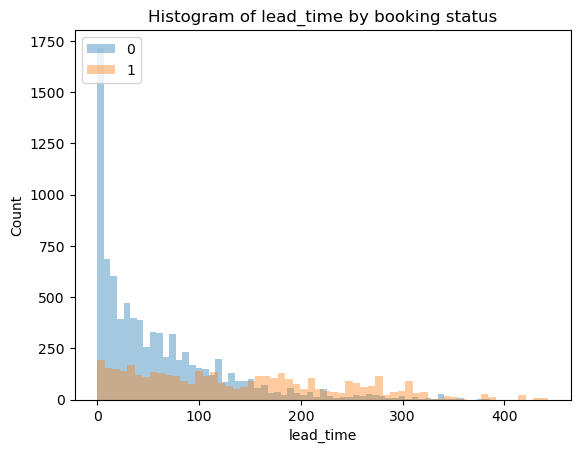

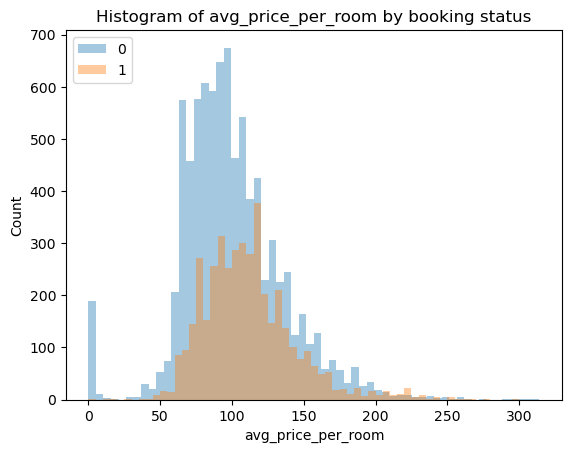

In [8]:
negative_examples = train_df.query("booking_status == 0")
positive_examples = train_df.query("booking_status == 1")

feat = ["lead_time", "avg_price_per_room"]

for i in feat:
    plt.hist(negative_examples[i], label = "0", alpha = 0.4, bins = 60)
    plt.hist(positive_examples[i], label = "1", alpha = 0.4, bins = 60)
    plt.legend(loc = "upper left", fontsize = 10)
    plt.ylabel("Count")
    plt.xlabel(i)
    plt.title("Histogram of " + i + " by booking status")
    plt.show()

*From the histogram, we can say that if the lead time is greater than 150, then we predict class 1. But by looking at the average price per room, the distribution of two classes overlap, making it difficult to classify based on this feature alone. Note that there is also an average price per room of 0, which we are not sure about.*

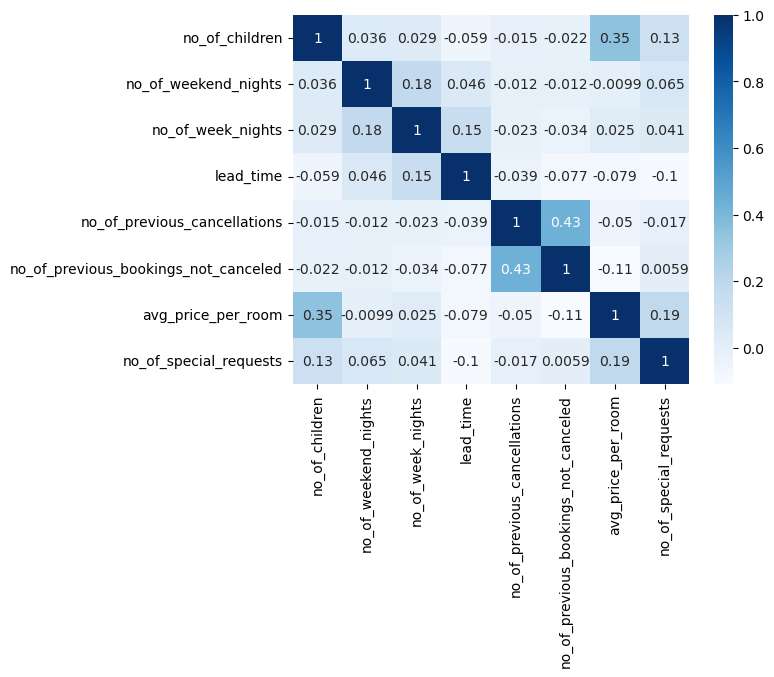

In [9]:
numeric_features = ["no_of_children",
                   "no_of_weekend_nights", 
                   "no_of_week_nights",
                   "lead_time", 
                   "no_of_previous_cancellations",
                  "no_of_previous_bookings_not_canceled", 
                   "avg_price_per_room",
                  "no_of_special_requests"]
cor = train_df[numeric_features].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

*By looking at only the numeric features, we see that the highest positive correlation occur between number of previous bookings not canceled and number of previous booking cancelled, which suggests some linear relationship in between the two features. Overall, a lot of the features have relative low correlation in terms of magnitude.*

<br><br>

## 4. Feature engineering <a name="4"></a>
<hr>

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

*We decided not to do feature engineering with columns number of previous cancelled, number of precious bookings not canceled, number of week nights and number of weekend nights. We thought that finding the ratio between the variables could be something useful. However, since the columns for these features were pretty sparse, the newly generated ratio column would generate a lot of NA or inf values. Imputing those with mean, median, or a constant fill value would be misleading in the analysis.*

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [10]:
X_train = train_df.drop(columns=["booking_status"])
X_test = test_df.drop(columns=["booking_status"])

y_train = train_df["booking_status"]
y_test = test_df["booking_status"]

In [11]:
drop_features = ["arrival_date"]
numeric_features = ["no_of_children",
                   "no_of_weekend_nights", 
                   "no_of_week_nights",
                   "lead_time", 
                   "no_of_previous_cancellations",
                  "no_of_previous_bookings_not_canceled", 
                   "avg_price_per_room",
                  "no_of_special_requests"]
binary_features = ["required_car_parking_space", "repeated_guest"]
categorical_features = ["type_of_meal_plan",
                    "room_type_reserved",
                     "arrival_year",
                     "arrival_month",
                     "market_segment_type"]

In [12]:
numeric_transformer = make_pipeline(
    StandardScaler()
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary", dtype=int),
)

ct = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [13]:
transformed = ct.fit_transform(X_train, y_train)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [14]:
scoring = [
    "recall", "accuracy", "precision"
]

In [15]:
pipe_baseline = make_pipeline(ct, DummyClassifier(strategy = "stratified"))
res = cross_validate(
    pipe_baseline, X_train, y_train, return_train_score = True, cv = 5, scoring = scoring
)
pd.DataFrame(res)

,fit_time,score_time,test_recall,train_recall,test_accuracy,train_accuracy,test_precision,train_precision
0,0.038318,0.020682,0.340095,0.329952,0.549823,0.558192,0.325714,0.330445
1,0.024867,0.017822,0.319809,0.318914,0.554943,0.554254,0.323671,0.322668
2,0.040157,0.025071,0.332936,0.319511,0.553367,0.555829,0.326698,0.324447
3,0.036966,0.024384,0.319809,0.325477,0.554155,0.557208,0.322892,0.327923
4,0.034516,0.019687,0.346062,0.326969,0.567546,0.562229,0.345238,0.333536


In [16]:
pd.DataFrame(res).mean()

fit_time           0.034965
score_time         0.021529
test_recall        0.331742
train_recall       0.324165
test_accuracy      0.555967
train_accuracy     0.557542
test_precision     0.328843
train_precision    0.327804
dtype: float64

<br><br>

## 7. Linear models <a name="7"></a>
<hr>

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [17]:
pipe_logreg = make_pipeline(ct, LogisticRegression(max_iter = 2000))

param_grid = {
    "logisticregression__C": (1, 10, 50, 100, 500, 1000)
}

grid_search = GridSearchCV(
    pipe_logreg, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring = scoring, refit = False
)
grid_search.fit(X_train, y_train)

results = (
    pd.DataFrame(grid_search.cv_results_).set_index("rank_test_recall").sort_index()
)
results.T

rank_test_recall,1,1,1,1,1,6
mean_fit_time,1.504239,1.354794,1.383097,1.23307,1.08253,0.745051
std_fit_time,0.068413,0.220623,0.271164,0.26225,0.180051,0.045204
mean_score_time,0.038638,0.041177,0.043777,0.052944,0.020545,0.042197
std_score_time,0.005103,0.003641,0.006859,0.020734,0.004058,0.009314
param_logisticregression__C,10,50,100,500,1000,1
params,{'logisticregression__C': 10},{'logisticregression__C': 50},{'logisticregression__C': 100},{'logisticregression__C': 500},{'logisticregression__C': 1000},{'logisticregression__C': 1}
split0_test_recall,0.668258,0.668258,0.668258,0.668258,0.668258,0.663484
split1_test_recall,0.658711,0.657518,0.657518,0.657518,0.657518,0.657518
split2_test_recall,0.652745,0.652745,0.652745,0.652745,0.652745,0.652745
split3_test_recall,0.634845,0.636038,0.636038,0.636038,0.636038,0.633652


*By performing Grid Search on all the values for C, we see that starting from C = 10 and onwards, the mean validation recall scores plateau. Therefore, we might be able to select C = 10 as the suitable hyperparameter for logistic regression. With this hyperparameter, the recall is 0.651074. If we choose C that is higher, we might risk overfitting the model. In this case, choosing C = 10 doesn't particularly overfit because the training recall score doesn't increase after this point (only slightly decreases) and the valiation recall score doesn't increase as well.*

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [18]:
models = {
    "logistic regression (with C = 10)": LogisticRegression(max_iter = 2000, C = 10),
    "random forest": RandomForestClassifier(random_state = 330, n_jobs = -1),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(random_state = 330, verbosity=0),
    "LGBM":  LGBMClassifier(random_state = 330)
}

In [19]:
alg = ["logistic regression (with C = 10)", "SVM", "random forest", "XGBoost", "LGBM"]

for i in alg:
    pipe = make_pipeline(
        ct,
        models[i]
    )
    results_dict[i] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score = True, cv = 5, scoring = ["recall", "accuracy", "precision"])

In [20]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_recall,train_recall,test_accuracy,train_accuracy,test_precision,train_precision
logistic regression (with C = 10),0.512 (+/- 0.088),0.017 (+/- 0.002),0.651 (+/- 0.013),0.653 (+/- 0.005),0.809 (+/- 0.006),0.810 (+/- 0.002),0.739 (+/- 0.012),0.742 (+/- 0.003)
SVM,4.510 (+/- 0.642),2.345 (+/- 0.312),0.692 (+/- 0.014),0.712 (+/- 0.003),0.831 (+/- 0.007),0.844 (+/- 0.002),0.773 (+/- 0.015),0.795 (+/- 0.004)
random forest,0.445 (+/- 0.019),0.048 (+/- 0.004),0.779 (+/- 0.004),0.992 (+/- 0.001),0.879 (+/- 0.005),0.996 (+/- 0.000),0.844 (+/- 0.013),0.995 (+/- 0.001)
XGBoost,0.604 (+/- 0.024),0.014 (+/- 0.001),0.782 (+/- 0.007),0.871 (+/- 0.004),0.880 (+/- 0.006),0.933 (+/- 0.002),0.843 (+/- 0.021),0.921 (+/- 0.004)
LGBM,0.103 (+/- 0.012),0.016 (+/- 0.000),0.778 (+/- 0.011),0.825 (+/- 0.004),0.878 (+/- 0.002),0.903 (+/- 0.002),0.839 (+/- 0.011),0.875 (+/- 0.004)


*As expected, with default parameters, the models we selected (SVM, RF, XGBoost, LGBM) all performed way better than logistic regression with C = 100. This fits for all metrics we have (recall, accuracy, precision). The best model; however, comes from XGBoost, with a recall score of 0.782. Random forest and LGBM have close enough recall scores and SVM beats logistic regression in recall score by 4%.*

<br><br>

## 9. Feature selection <a name="9"></a>
<hr>

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

In [21]:
pipe_rfe = make_pipeline(
    ct,
    RFECV(LogisticRegression(max_iter=2000), cv = 5),
    RandomForestClassifier(random_state = 330, n_jobs = -1)
)

pd.DataFrame(cross_validate(pipe_rfe, X_train, y_train, return_train_score=True, scoring = ["recall", "accuracy", "precision"])).mean()

fit_time           14.207835
score_time          0.052515
test_recall         0.772076
train_recall        0.991229
test_accuracy       0.875148
train_accuracy      0.995234
test_precision      0.837196
train_precision     0.994316
dtype: float64

*We decided to perform feature selection for random forest classifier since with the given computational resources, it might be an overhead to tune the hyperparameters for XGBoost or LGBM. (The recall for random forest and the other ensemble methods aren't that far apart anyway)*

*We see from the RFECV method, the recall and accuracy for random forest remained almost the same (with feature selection it decreases by a small amount) than with the full model with no feature selection. The precision after feature selection decreases by around 1%.* 

*Thus, since there is no improvement in all metrics for RFECV method, we would rather keep all the features in the model. We suspect that the no improvement in metrics may be from information loss due to removing some variables.*

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [22]:
pipe_best_default_model = make_pipeline(
    ct,
    RandomForestClassifier(random_state = 330, n_jobs = -1)
)

rfc_params = {
    "randomforestclassifier__n_estimators": [int(x) for x in np.linspace(start = 200, stop = 900, num = 10)],
    "randomforestclassifier__max_depth": [int(x) for x in np.linspace(10, 110, num = 11)]
}

random_search = RandomizedSearchCV(
    pipe_best_default_model, rfc_params, verbose = 0, n_iter = 40, random_state = 330, n_jobs = -1, scoring = "recall"
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['no_of_children',
                                                                                'no_of_weekend_nights',
                                                                                'no_of_week_nights',
                                                                                'lead_time',
                                                                                'no_of_previous_cancellations',
                                                                                'no_of_previous_bookings_not_canceled',
                                                                                'avg_price_per_room',
                                                                                'no_of_special_reque...
                                                                                'market_segment_type']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['arrival_date'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=330))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [10,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50,
                                                                              60,
                                                                              70,
                                                                              80,
                                                                              90,
                                                                              100,
                                                                              110],
                                        'randomforestclassifier__n_estimators': [200,
                                                                                 277,
                                                                                 355,
                                                                                 433,
                                                                                 511,
                                                                                 588,
                                                                                 666,
                                                                                 744,
                                                                                 822,
                                                                                 900]},
                   random_state=330, scoring='recall')

In [23]:
best_max_depth = random_search.best_params_["randomforestclassifier__max_depth"]
best_n_estimators = random_search.best_params_["randomforestclassifier__n_estimators"]
best_score_recall = random_search.best_score_

#print(best_weights)
print(best_max_depth)
print(best_n_estimators)
print(best_score_recall)

20
666
0.782816229116945


In [24]:
random_search.classes_

array([0, 1])

*We decided to tune hyperparamters from random forest classification with the given computational resources, it might be an overhead to tune the hyperparameters for XGBoost or LGBM. (The recall for random forest and the other ensemble methods aren't that far apart anyway).*

*We see that with the given set of hyperparameters via Random Search, we obtained the best recall score on the validation set with max_depth of 20 and 666 estimators. We get a recall of 0.783, which is an improvement from random forest with default hyperparameters.*

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [25]:
pipe_rf_tuned = make_pipeline(ct, 
                              RandomForestClassifier(random_state = 330, n_jobs = -1, max_depth = 20, n_estimators = 666)
)

ohe_feature_names = (
    pipe_rf_tuned.named_steps["columntransformer"]
    .named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names_out()
    .tolist()
)

feature_names = (
    numeric_features + binary_features + ohe_feature_names
)

In [26]:
pipe_rf_tuned.fit(X_train, y_train);
eli5.explain_weights(pipe_rf_tuned.named_steps["randomforestclassifier"], feature_names = feature_names)

Weight,Feature
0.3326 ± 0.0590,lead_time
0.1681 ± 0.0348,avg_price_per_room
0.1212 ± 0.0561,no_of_special_requests
0.0606 ± 0.0165,no_of_week_nights
0.0430 ± 0.0125,no_of_weekend_nights
0.0333 ± 0.0443,market_segment_type_1
0.0205 ± 0.0356,arrival_year_2017
0.0190 ± 0.0299,market_segment_type_0
0.0180 ± 0.0343,arrival_year_2018
0.0179 ± 0.0081,arrival_month_12


In [27]:
data = {
    "Importance": pipe_rf_tuned.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data = data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:20]

,Importance
lead_time,0.332564
avg_price_per_room,0.168109
no_of_special_requests,0.121225
no_of_week_nights,0.060616
no_of_weekend_nights,0.043019
market_segment_type_1,0.033323
arrival_year_2017,0.020540
market_segment_type_0,0.019004
arrival_year_2018,0.018006
arrival_month_12,0.017929


*From running random forest with the best hyperparameters chosen in part 10, we see that the most important top 5 features come from lead time, average price per room, number of special requests, number of week nights, and number of weekend nights. The results from eli5 matches with the feature importance calculation from sklearn.*

*This means that based on the given data about customers, the lead time, average price per room, number of special requests, number of week nights, and number of weekend nights can tell us how likely the customer is to cancel or keep the booking.*

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [28]:
random_search.score(X_test, y_test)

0.7962328767123288

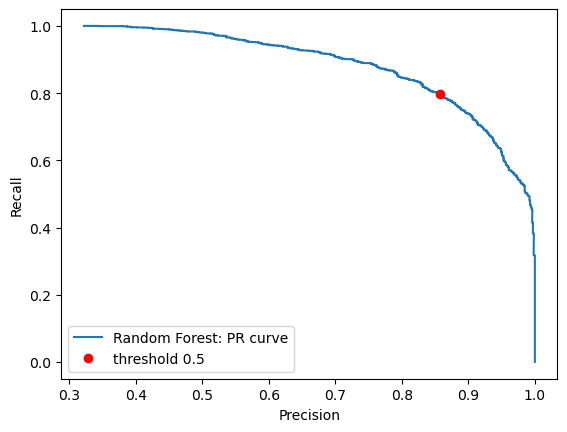

In [29]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

precision, recall, thresholds = precision_recall_curve(
    y_test, random_search.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="Random Forest: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, random_search.predict(X_test)),
    recall_score(y_test, random_search.predict(X_test)),
    "or",
    markersize=6,
    label="threshold 0.5",
)
plt.legend(loc="best");

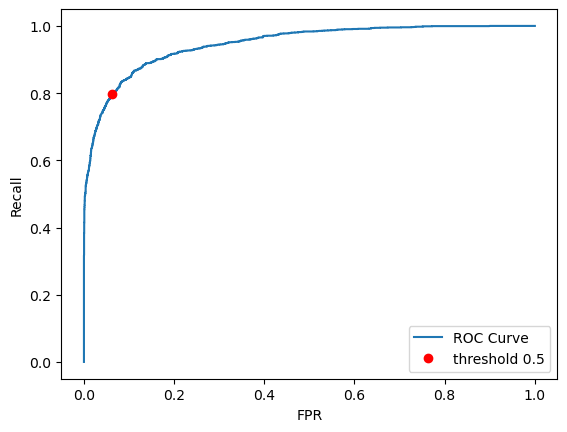

In [30]:
# ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, random_search.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("Recall")

threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[threshold],
    tpr[threshold],
    "or",
    markersize=6,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [31]:
# AUC score
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, random_search.predict_proba(X_test)[:, 1])
auc

0.946891202930294

*The resulting test recall score is 0.796, which is just higher than the validation recall score by around 1.3%. We don't particularly think that there is an optimization bias going on since the validation score isn't way higher than the testing score. The performance of the model during cross validation is comparable to running on the whole test set.*

*Even though we don't think there is an optimization bias, it could also be due to luck that the testing set looks a lot like the training/validation set, resulting in close enoough recall scores.*

*The computed AUC score is 0.947, which is quite high. Since the AUC is close to 1, it indicates that the model is more confident in it's predictions for positive points than negative points, as it has a higher predict_proba score.*

*Just by looking at the precision-recall curve and the ROC plot, our model performs relatively well. At threshold of 50% for predict_proba, our recall is at 80% while keeping a relatively low false positive rate and high precision. Again, we may not be very confident about this as this could also be due to luck.*

<br><br>

## 13. Summary of results <a name="13"></a>
<hr>

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

*Our test score is 0.796 and this represents the recall score that the model achieved on the test set. We selected recall because we are interested in finding out customers that are likely to cancel their booking status.*

*Overall, our random forest classifier performs relatively well with good enough recall and precision. Although recall is the most important metric here that is used to explain the data and identifying the class of interest, we could potentially try to look at the accuracy score just to judge how well the model performs overall.*

*Comparing to the baseline (DummyClassifier and LogisticRegression(C = 10)), we get a very good score. Although we were expecting that during hyperparameter tuning, our random forest should give a significantly higher cross-validation recall score than the random forest with default hyperparameters, it seems like random forest itself is already a high-performing model, thus with the default hyperparameters, the score itself is sufficient.*

*There could be a possibility that we may be overfitting our model. Since the training recall is quite high for random forest (see part 8), we should investigate on the training and validation score graph and observe the sweet spot for our hyperparameters. Note that in part 8, we fit complete random forest and let it fully grow to maximum depth, so it is likely overfitting could happen there.*

*We are not sure whether optimization bias really happened or if it is just due to luck that the test set and the training set looks similar. It is shown that the validation score and the test score are pretty close and we concluded that the validation score is representative of the testing score. If we have access to a larger dataset than this, perhaps, this could be something we would look into.*

*As for further improvements, we could try to perform hyperparameter tunings and other models (ie. LogisticRegression, XGBoost, SVC, etc...) and compare the scores with our current random forest model. Because we see some sort of class imbalance in this dataset, we could potentially try to adjust the class weights in the models as well. We could also try to check the performance of the model with just including the most important features and see if the model performance is similar or better with just those features on the test set. However, part 9 suggests, there is no improvement in scores but this could be due to scome information loss.*